In [2]:
%matplotlib inline

In [2]:
import urllib.request
import io
import zipfile

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

import igraph as ig

In [3]:
G = nx.petersen_graph()
#subax1 = plt.subplot(121)
#nx.draw(G, with_labels=True, font_weight='bold')
#subax2 = plt.subplot(122)
#nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

In [4]:
print(list(G.nodes))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [5]:
print(list(G.edges))

[(0, 1), (0, 4), (0, 5), (1, 2), (1, 6), (2, 3), (2, 7), (3, 4), (3, 8), (4, 9), (5, 7), (5, 8), (6, 8), (6, 9), (7, 9)]


In [6]:
list(G.adj[1])  # or list(G.neighbors(1))

[0, 2, 6]

In [7]:
G.degree[1]  # the number of edges incident to 1

3

In [9]:
nx.maximal_independent_set(G) 

[6, 5, 2, 4]

In [10]:
N = nx.neighbors(G,1)
for i in N:
    print(i)

0
2
6


In [12]:
path = nx.single_source_dijkstra_path(G, 0)
path

{0: [0],
 1: [0, 1],
 4: [0, 4],
 5: [0, 5],
 2: [0, 1, 2],
 6: [0, 1, 6],
 3: [0, 4, 3],
 9: [0, 4, 9],
 7: [0, 5, 7],
 8: [0, 5, 8]}

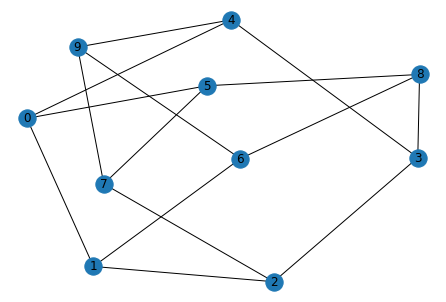

In [13]:
nx.draw(G, with_labels=True)
plt.show()

In [14]:
N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

dm = np.zeros((N,N), dtype=int)

p = nx.nx.shortest_path(G)
for i in range(0,N):
    for j in range(0,N):
        dm[i][j] = len(p[i][j])-1


In [15]:
N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

lb = np.zeros((N), dtype=int)
ub = np.zeros((N), dtype=int)
time = np.zeros((N), dtype=int)
gap = np.zeros((N), dtype=int)
nodes = np.zeros((N), dtype=int)

for i in G:

    model = gp.Model("tukey") #cria o modelo

    x = model.addVars(N, vtype=GRB.BINARY, name='x') #Adicionando Variáveis 
    
    obj = 0
    for j in G:
        obj += 1 * x[j]
         
    model.setObjective(obj, GRB.MINIMIZE)
    
    # configurando parametros
    # model.Params.TimeLimit = 60
    model.Params.MIPGap = 1.e-6
    model.Params.Threads = 1
    # model.Params.Presolve = 0
    # model.Params.Cuts = 0
 
    # Turn off display and heuristics
    gp.setParam('OutputFlag', 0)
    gp.setParam('Heuristics', 0)

    constr0 = 0
    constr0 += 1*x[i]
    model.addConstr(constr0 == 1)

    for u in range(0,N):
        for w in range(u+1,N):
            if dm[u,w] <= N:
                for s in range(0,N):
                    if (s != u) and (s != w):
                        if (dm[u,s] + dm[s,w] == dm[u,w]):
                            constr1 = x[u] + x[w]
                            model.addConstr(constr1 >= x[s])

    #relax = model.relax()    
    #relax.optimize()

    model.optimize()
    
    lb[i] = model.objBound
    ub[i] = model.objVal
    gap[i] = model.MIPGap
    time[i] = model.Runtime
    nodes[i] = model.NodeCount

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-01
Set parameter MIPGap to value 1e-06
Set parameter Threads to value 1


In [16]:
t = 0
for i in ub:
    print("tukey[%d] =" %t, end=" ")
    print("%g" %i)
    t = t+1

tukey[0] = 5
tukey[1] = 5
tukey[2] = 5
tukey[3] = 5
tukey[4] = 5
tukey[5] = 5
tukey[6] = 5
tukey[7] = 5
tukey[8] = 5
tukey[9] = 5


In [17]:
N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

lb = np.zeros((N), dtype=int)
ub = np.zeros((N), dtype=int)
time = np.zeros((N), dtype=int)
gap = np.zeros((N), dtype=int)
nodes = np.zeros((N), dtype=int)

for i in G:

    model = gp.Model("tukey") #cria o modelo

    # configurando parametros
    # model.Params.TimeLimit = 60
    model.Params.MIPGap = 1.e-6
    model.Params.Threads = 1
    # model.Params.Presolve = 0
    # model.Params.Cuts = 0

    x = model.addVars(N, vtype=GRB.BINARY, name='x') #Adicionando Variáveis 
    
    obj = 0
    for j in G:
        obj += 1 * x[j]
         
    model.setObjective(obj, GRB.MAXIMIZE)
     
    # Turn off display and heuristics
    gp.setParam('OutputFlag', 0)
    gp.setParam('Heuristics', 0)

    constr0 = 0
    constr0 += 1 * x[i]
    model.addConstr(constr0 == 0)

    for u in range(0,N):
        for w in range(u+1,N):
            if dm[u,w] <= N:
                for s in range(0,N):
                    if (s != u) and (s != w):
                        if (dm[u,s] + dm[s,w] == dm[u,w]):
                            constr1 = x[u] + x[w]
                            model.addConstr(constr1 <= 1 + x[s])

    #relax = model.relax()
    #relax.optimize()

    model.optimize()

    lb[i] = N - model.objBound
    ub[i] = N - model.objVal
    gap[i] = model.MIPGap
    time[i] = model.Runtime
    nodes[i] = model.NodeCount

In [18]:
t = 0
for i in ub:
    print("tukey[%d] =" %t, end=" ")
    print("%g" %i)
    t = t+1

tukey[0] = 5
tukey[1] = 5
tukey[2] = 5
tukey[3] = 5
tukey[4] = 5
tukey[5] = 5
tukey[6] = 5
tukey[7] = 5
tukey[8] = 5
tukey[9] = 5


In [19]:
N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

lb = np.zeros((N), dtype=int)
ub = np.zeros((N), dtype=int)
time = np.zeros((N), dtype=int)
gap = np.zeros((N), dtype=int)
nodes = np.zeros((N), dtype=int)

for i in G:

    model = gp.Model("tukey") #cria o modelo

    # configurando parametros
    # model.Params.TimeLimit = 60
    model.Params.MIPGap = 1.e-6
    model.Params.Threads = 1
    # model.Params.Presolve = 0
    # model.Params.Cuts = 0

    x = model.addVars(N, vtype=GRB.BINARY, name='x') #Adicionando Variáveis 
    
    obj = 0
    for j in G:
        obj += 1 * x[j]
         
    model.setObjective(obj, GRB.MAXIMIZE)
     
    # Turn off display and heuristics
    gp.setParam('OutputFlag', 0)
    gp.setParam('Heuristics', 0)

    constr0 = 0
    constr0 += 1 * x[i]
    model.addConstr(constr0 == 0)

    for u in range(0,N):
        for w in range(u+1,N):
            if dm[u,w] <= N:
                for s in range(0,N):
                    if (s != u) and (s != w):
                        if (dm[u,s] + dm[s,w] == dm[u,w]):
                            constr1 = x[u] + x[w]
                            model.addConstr(constr1 <= 1 + x[s])

                            Is = nx.maximal_independent_set(G, [s])
                            for k in Is:
                                constr2 = 1 * x[k]
                            constr2 += 1 + (len(Is)- 1)*x[s]                            

    #relax = model.relax()
    #relax.optimize()

    model.optimize()

    lb[i] = N - model.objBound
    ub[i] = N - model.objVal
    gap[i] = model.MIPGap
    time[i] = model.Runtime
    nodes[i] = model.NodeCount

In [20]:
t = 0
for i in ub:
    print("tukey[%d] =" %t, end=" ")
    print("%g" %i)
    t = t+1

tukey[0] = 5
tukey[1] = 5
tukey[2] = 5
tukey[3] = 5
tukey[4] = 5
tukey[5] = 5
tukey[6] = 5
tukey[7] = 5
tukey[8] = 5
tukey[9] = 5
